In [2]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [3]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=1) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='+', s=marker_size)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='+', s=marker_size)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True, save=False, filepath=None):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        if save and filepath is not None:
            plt.savefig(filepath)
        plt.axis('off')
        plt.show()

def show_image_with_points(image, point_coords=None, box_coords=None, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
    if box_coords is not None:
        # boxes
        show_box(box_coords, plt.gca())
    plt.axis('on')
    plt.show()
    plt.close()

In [12]:
# Image: 0
image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_12012y_1'
image_filename = '7z.png'

# Image: 1
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_11520y_1'
# image_filename = '7z.png'

# Image 2
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_12012y_1'
# image_filename = '7z.png'

# Image 3
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_21504y_1'
# image_filename = '7z.png'

# Image: 4
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_26796y_1'
# image_filename = '7z.png'

# Image: 5
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_26880y_1'
# image_filename = '7z.png'

# Image: 7
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_40704y_1'
# image_filename = '2z.png'

# Image: 8
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_41472y_1'
# image_filename = '7z.png'

# Image: 9
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_43776y_1'
# image_filename = '7z.png'

# Image: 10
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_46848y_1'
# image_filename = '7z.png'

# Image: 11
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_56064y_1'
# image_filename = '6.png'

# Image 12
# image_folder = 'images/PAL1999/PAL1999_B2_sample101_slide1_0x_56064y_2'
# image_filename = '7z.png'

# Image 13
# image_folder = 'images/PAL1999/PAL1999_C3_sample22_slide1_23552x_34816y_1'
# image_filename = '5z.png'

image = Image.open(image_folder + '/' + image_filename)
image = np.array(image.convert("RGB"))

threshold = 100
circular_mask_image = Image.open(image_folder + '/' + 'mask_1.png')
circular_mask_image = circular_mask_image.convert('L')
circular_mask_image = circular_mask_image.point( lambda p: 255 if p > threshold else 0 )
circular_mask_image = circular_mask_image.convert('1')
circular_mask = np.array(circular_mask_image)
circular_mask = circular_mask.reshape((1, circular_mask.shape[0], circular_mask.shape[1]))

print(circular_mask)



[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


In [13]:
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

In [14]:
predictor.set_image(image)

In [15]:
with open(image_folder + '/metadata_1.json', "r") as f:
    metadata = json.load(f)
    print(metadata)

str_top_left, str_bottom_right = str(metadata['pollen_image_coordinates']).split(', ')

x1 = int(str_top_left.split(',')[0].split('((')[1])
y1 = int(str_top_left.split(',')[1].split(')')[0])

x2 = int(str_bottom_right.split(',')[0].split('(')[1])
y2 = int(str_bottom_right.split(',')[1].split('))')[0])

center_x = int((x2 - x1)/2)
center_y = int((y2 - y1)/2)

input_point = np.array([[center_x, center_y]])
input_label = np.array([1])

{'sample_filename': 'PAL1999_B2_sample101_slide1', 'tile_image_coordinates': '0x_12012y', 'pollen_image_coordinates': '((124,29), (268,173))', 'pollen_image_global_coordinates': '((124,12041), (268,12185))', 'confidence': 0.6667100787162781, 'processed_datetime_utc': '2024-07-31T13:28:48.897Z'}


In [16]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

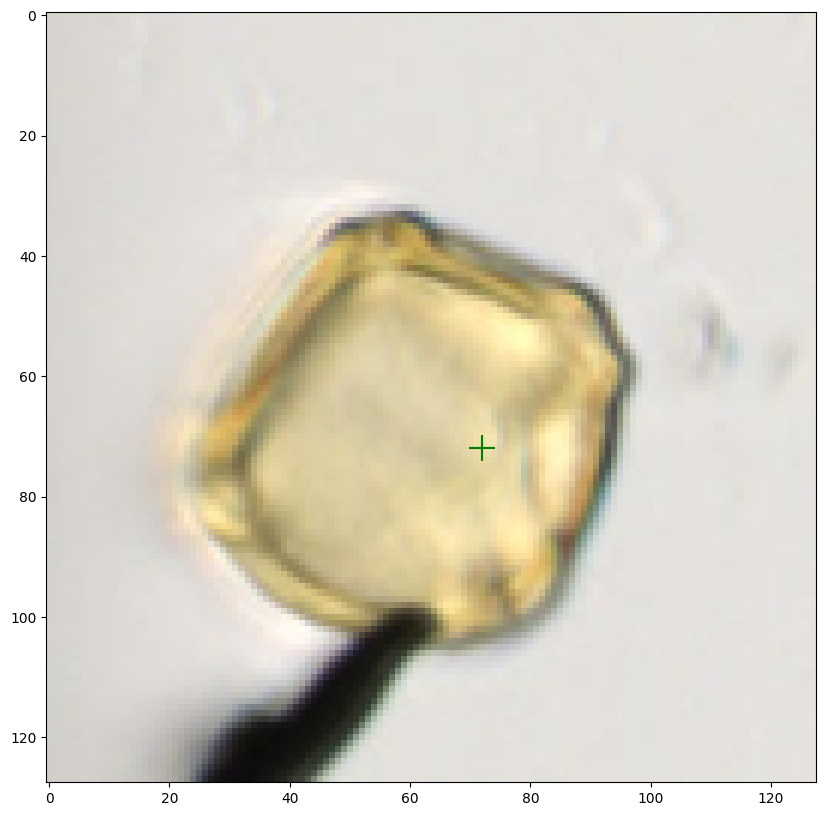

In [17]:
plt.close()
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.savefig(image_folder + '/' + 'prompt_image.png')
plt.show()
plt.close()

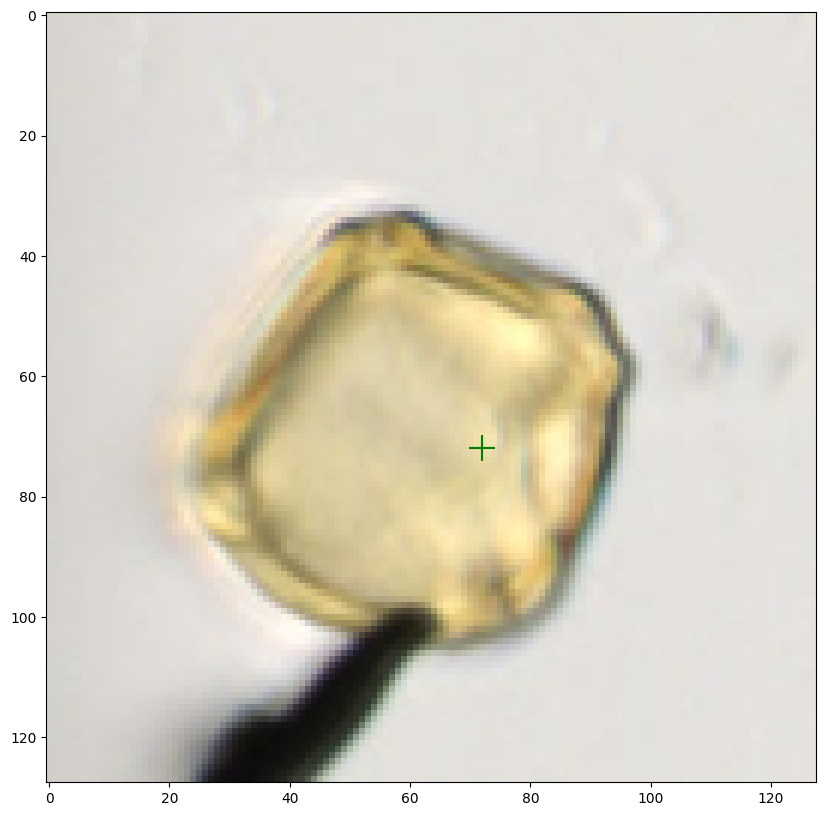

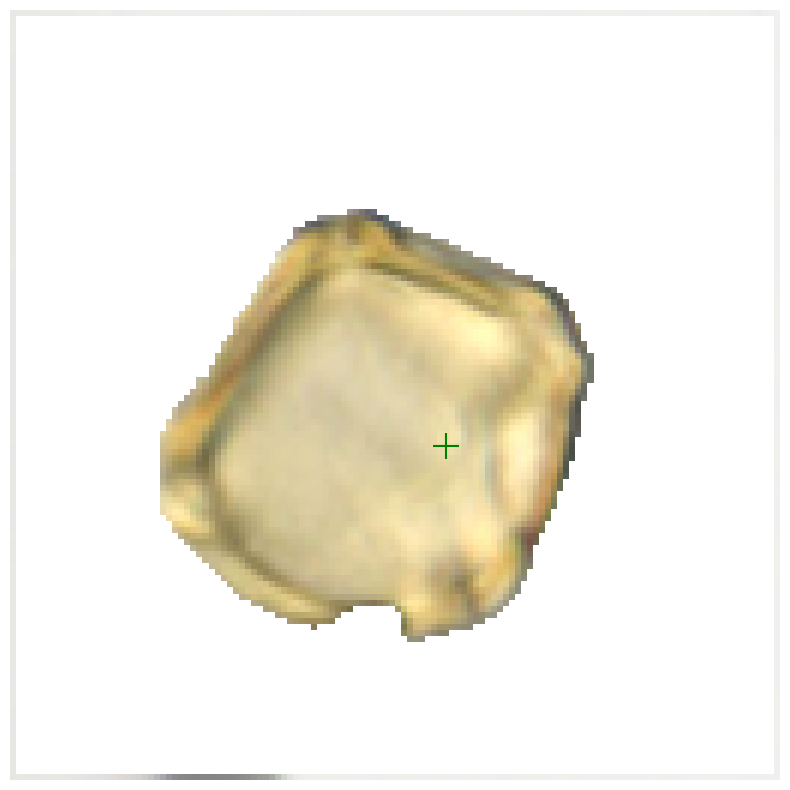

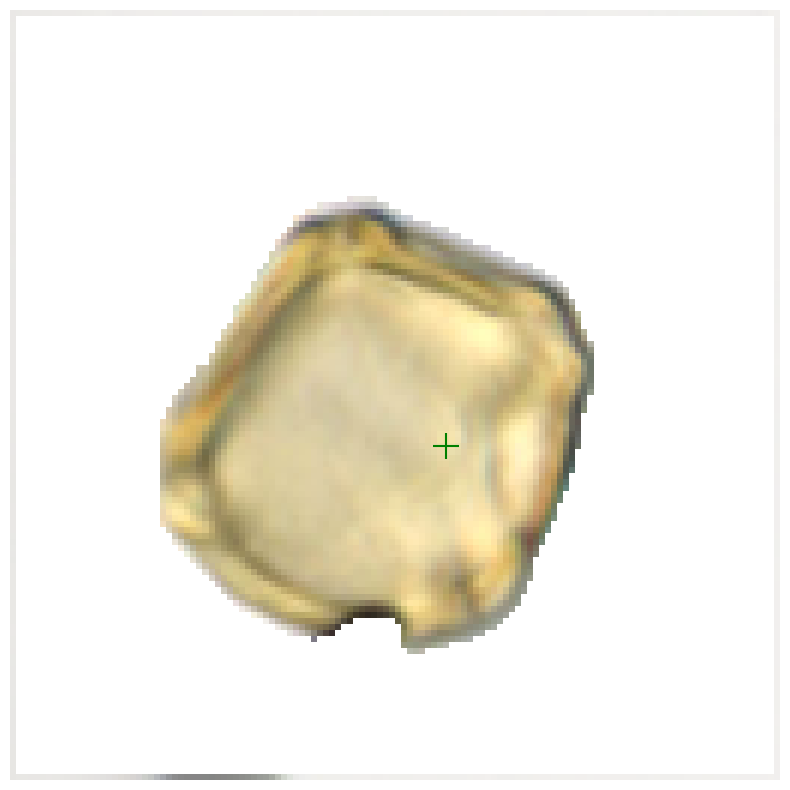

In [18]:
import cv2 as cv
import numpy as np

kernel = np.ones((5,5),np.uint8)
mask = masks[:1]
mask = (mask * 255).round().astype(np.uint8)
inverted_mask = cv.bitwise_not(mask) 
score = scores[:1]
dilated_mask = cv.dilate(mask,kernel,iterations=1)
inverted_dilated_mask = cv.bitwise_not(dilated_mask) 
# inverted_circular_mask = cv.bitwise_not(circular_mask) 

show_image_with_points(image, point_coords=input_point, input_labels=input_label)

# filepath = image_folder + '/' + 'circular_mask_applied.png'
# show_masks(image, inverted_circular_mask, score, borders=True, save=True, filepath=filepath)

filepath = image_folder + '/' + 'segmentation_mask_applied.png'
show_masks(image, inverted_mask, score, point_coords=input_point, input_labels=input_label, borders=True, save=True, filepath=filepath)

filepath = image_folder + '/' + 'segmentation_mask_applied_after_dilation.png'
show_masks(image, inverted_dilated_mask, score, point_coords=input_point, input_labels=input_label, borders=True, save=True, filepath=filepath)